### **Task 1 Summary: PageRank Algorithm**

We implemented the PageRank algorithm using a 4×4 web-link matrix to measure the importance of each page.  
Using both the **eigenvector** and **power iteration** methods, we computed the steady-state probabilities and confirmed they matched.  
Pages **3 and 4** tied as the most important, each with a PageRank of **0.3158**, since they receive strong links from other high-ranked pages.  
The PageRank values represent the long-run probabilities of a random surfer being on each page.


Column sums (should all be 1): [1. 1. 1. 1.]

 PageRank via Dominant Eigenvector 
Eigenvalue closest to 1: (1.0000000000000002+0j)
PageRank (eigen): [0.15789474 0.21052632 0.31578947 0.31578947]
PageRank via Power Iteration
PageRank (power): [0.15789474 0.21052632 0.31578947 0.31578947]
Converged in 22 iterations; final L1 diff = 6.730e-13
Consistency Check (Eigenvector vs Power)
L1 discrepancy = 1.772e-13

Top pages (tie): 3, 4 with score 0.315789

Why Page 3 is tied for highest (contribution breakdown):
  From page 1: link prob=0.333, source rank=0.157895, contribution=0.052632
  From page 2: link prob=0.500, source rank=0.210526, contribution=0.105263
  From page 4: link prob=0.500, source rank=0.315789, contribution=0.157895
  (These contributions sum to 0.315789 ≈ Page 3's rank)

Why Page 4 is tied for highest (contribution breakdown):
  From page 1: link prob=0.333, source rank=0.157895, contribution=0.052632
  From page 2: link prob=0.500, source rank=0.210526, contribution=0.10

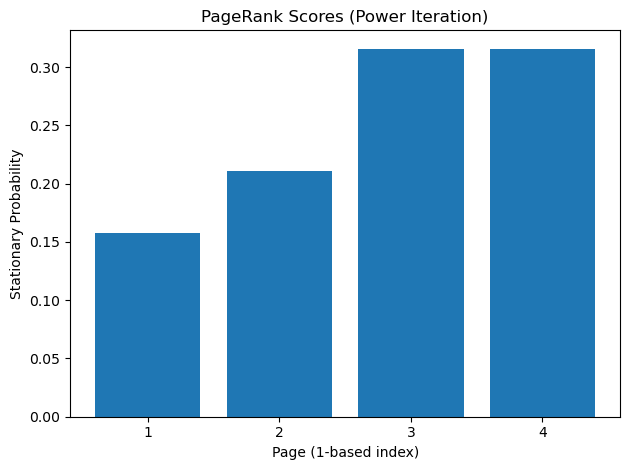

In [2]:
import numpy as np  # we import numpy to handle all numerical and matrix operations
import matplotlib.pyplot as plt  # we import matplotlib to visualize the PageRank results

M = np.array([  # we define the 4x4 column-stochastic matrix M exactly as given in the assignment
    [0.0,  0.0,  1/2, 0.0],   # we set row 1 to show probabilities of landing on page 1 from pages 1..4
    [1/3,  0.0,  0.0, 1/2],   # we set row 2 to show probabilities of landing on page 2 from pages 1..4
    [1/3,  1/2,  0.0, 1/2],   # we set row 3 to show probabilities of landing on page 3 from pages 1..4
    [1/3,  1/2,  1/2, 0.0],   # we set row 4 to show probabilities of landing on page 4 from pages 1..4
], dtype=float)  # we ensure floating point arithmetic

col_sums = M.sum(axis=0)  # we compute column sums to verify the column-stochastic property
print("Column sums (should all be 1):", col_sums)  # we print the column sums to document correctness
assert np.allclose(col_sums, 1.0, atol=1e-12), "Matrix M must be column-stochastic"  # we enforce that each column sums to 1

def normalize_prob(v):  # we define a helper function to normalize a vector to a probability distribution
    s = v.sum()  # we compute the sum of the vector entries
    if s <= 0:  # we guard against degenerate cases due to numerical issues
        return np.ones_like(v) / v.size  # we return a uniform distribution if the sum is nonpositive
    return v / s  # we return the normalized vector that sums to 1

try:  # we try to use SciPy for eigen-decomposition for better numerical behavior
    import scipy.linalg as la  # we import scipy.linalg for eigen computations
    evals, evecs = la.eig(M)  # we compute eigenvalues and right eigenvectors of M
except Exception:  # we fall back to NumPy if SciPy is unavailable
    evals, evecs = np.linalg.eig(M)  # we compute eigenpairs using NumPy

idx_one = np.argmin(np.abs(evals - 1.0))  # we find the index of the eigenvalue closest to 1
v_eig_raw = np.real(evecs[:, idx_one])  # we take the real part of the corresponding eigenvector
v_eig = np.clip(v_eig_raw, 0.0, None)  # we clip tiny negative values to zero to maintain nonnegativity
v_eig = normalize_prob(v_eig)  # we normalize to obtain a valid probability vector

print("\n PageRank via Dominant Eigenvector ")  # we label the eigenvector-based results
print("Eigenvalue closest to 1:", evals[idx_one])  # we print the eigenvalue near 1 for reference
print("PageRank (eigen):", v_eig)  # we print the normalized eigenvector as PageRank scores

v = np.ones(M.shape[0])  # we start power iteration from a vector of ones as requested
v = normalize_prob(v)  # we normalize the initial vector to a probability distribution
tol = 1e-12  # we set a strict L1 tolerance for convergence
max_iter = 10000  # we cap the number of iterations for safety

for k in range(max_iter):  # we iterate the power method until convergence
    v_next = M @ v  # we propagate the rank vector by multiplying with M
    v_next = normalize_prob(v_next)  # we normalize to maintain a probability interpretation
    diff = np.linalg.norm(v_next - v, ord=1)  # we compute the L1 difference between successive iterates
    v = v_next  # we update the vector for the next iteration
    if diff < tol:  # we check if the iterate has converged within tolerance
        break  # we stop iterating when convergence is achieved

v_power = v  # we store the converged PageRank vector from power iteration
print("PageRank via Power Iteration")  # we label the power-iteration results
print("PageRank (power):", v_power)  # we print the converged PageRank scores
print(f"Converged in {k+1} iterations; final L1 diff = {diff:.3e}")  # we report how many iterations were needed and the final difference

L1_gap = np.linalg.norm(v_eig - v_power, ord=1)  # we measure the L1 discrepancy between both methods
print("Consistency Check (Eigenvector vs Power)")  # we label the consistency check
print(f"L1 discrepancy = {L1_gap:.3e}")  # we print how close the two PageRank solutions are

assert np.allclose(M @ v_power, v_power, atol=1e-10), "Power-iteration result is not stationary within tolerance"  # we verify that Mv = v holds within tolerance

eps = 1e-12  # we set a tolerance to detect ties due to floating-point noise
max_score = v_power.max()  # we get the maximum PageRank score
winners = np.flatnonzero(np.abs(v_power - max_score) <= eps) + 1  # we collect all 1-based page indices tied for top rank

if winners.size == 1:  # we handle the case of a unique top-ranked page
    top_page = int(winners[0])  # we extract the 1-based page number
    print(f"\nHighest ranked page: Page {top_page} with score {max_score:.6f}")  # we report the highest-ranked page and its score
    contribs = M[top_page-1, :] * v_power  # we compute contributions from each source page to this winner
    print(f"\nWhy Page {top_page} is highest (contribution breakdown):")  # we explain why the winner ranks highest
    for j, c in enumerate(contribs, start=1):  # we iterate over all potential source pages
        if M[top_page-1, j-1] > 0:  # we only display pages that actually link to the winner
            print(f"  From page {j}: link prob={M[top_page-1, j-1]:.3f}, source rank={v_power[j-1]:.6f}, contribution={c:.6f}")  # we show probability, source rank, and contribution
    print(f"  (These contributions sum to {contribs.sum():.6f} ≈ Page {top_page}'s rank)")  # we confirm the contributions sum to the page’s rank
else:  # we handle the case of a tie among multiple pages
    pages_list = ", ".join(map(str, winners.tolist()))  # we format the list of tied pages
    print(f"\nTop pages (tie): {pages_list} with score {max_score:.6f}")  # we report all co-winners and their shared score
    for p in winners:  # we print a contribution breakdown for each co-winner
        contribs = M[p-1, :] * v_power  # we compute contributions to page p from all source pages
        print(f"\nWhy Page {int(p)} is tied for highest (contribution breakdown):")  # we label the explanation for this page
        for j, c in enumerate(contribs, start=1):  # we iterate over all potential source pages
            if M[p-1, j-1] > 0:  # we only show nonzero links contributing to this page
                print(f"  From page {j}: link prob={M[p-1, j-1]:.3f}, source rank={v_power[j-1]:.6f}, contribution={c:.6f}")  # we show detailed contributions
        print(f"  (These contributions sum to {contribs.sum():.6f} ≈ Page {int(p)}'s rank)")  # we confirm the sum matches the page’s rank

print("\nLong-run visit probabilities (interpretation):")  # we interpret each entry of the PageRank vector
for i, val in enumerate(v_power, start=1):  # we loop over the pages to report steady-state probabilities
    print(f"  Page {i}: π_i ≈ {val:.6f}")  # we print the long-run probability of being on each page

pages = np.arange(1, M.shape[0] + 1)  # we create page labels 1..n for plotting
plt.bar(pages, v_power)  # we create a bar chart of the PageRank scores from the power iteration
plt.title("PageRank Scores (Power Iteration)")  # we add a title to the plot
plt.xlabel("Page (1-based index)")  # we label the x-axis with page numbers
plt.ylabel("Stationary Probability")  # we label the y-axis to indicate probabilities
plt.xticks(pages)  # we ensure each page number appears on the x-axis

plt.tight_layout()  # adjust layout to prevent label overlap
plt.savefig("pagerank_scores.png", dpi=300, bbox_inches='tight')  # save the figure
plt.show()  # display the plot
